# Task 2

Requirements:
```
qiskit
numpy
matplotlib
```

In [1]:
from qiskit import QuantumCircuit, execute, Aer
import numpy as np
import matplotlib.pyplot as plt
backend = Aer.get_backend('qasm_simulator')
from numpy.random import randint

## Part 1, main task
This task is a first step to learn the power of quantum error correction via bit and phase flip codes. The setting of this task however is very simple and does not actually show the power of the mentioned codes. For a detailed generalization of this experiment please refer to part 2.

### Analysis of the statevector

The state vector right before CNOT gate is $\psi_1=\frac{1}{\sqrt 2}(|00\rangle+|10\rangle)=|+\rangle\otimes|0\rangle$. After CNOT it is $\psi_2=\frac{1}{\sqrt 2}(|00\rangle+|11\rangle)$. The real power of quantum error correction is that it can correct arbitrary quantum errors. This property can not be shown and used if our only tool is just computational basis measurements. In fact for the Bell state in question, the state $\frac{1}{\sqrt 2}(|00\rangle+e^{i\theta}|11\rangle)$ for any $\theta$ will also return the same set of probabilities for measurement results. To see the difference we need more sophisticated tools like quantum state tomography. 

### Effect of Paulies on $\psi_1$
Again remember the effects are only studied based on the outcome probabilities after measurement, not the state vector.

#### Claim: $Z$ and $X$ have no effect on first wire
Proof: If we apply a Pauli $X$ or $Z$ on first wire the state vector right before CNOT is $|+\rangle\otimes|0\rangle$ for $X$ and is $|-\rangle\otimes|0\rangle$ for Z. Then the final state vector afte CNOT is $\frac{1}{\sqrt 2}(|00\rangle+|11\rangle)$ or $\frac{1}{\sqrt 2}(|00\rangle-|11\rangle)$ respectively. In both cases the probabilty of outcome is $50,50$ for $|00\rangle$ and $|11\rangle$ which is the same as Bell state.

#### Claim: $Z$ has no effect on second wire
Proof: As the circuit starts from $|0\rangle$ and $|0\rangle$ is a $+1$ eigenvector of $Z$, applying $Z$ on second wire will not change the state vector at all.

#### Claim: A bit-flip code on second wire will correct any $Z$ and/or $X$ errors on both wires
Proof: Trivial based on two claims above.

### Numerical experiment
Based on discussion above the following circuit can detect and correct any arbitrary $Z$ and/or $X$ error right before CNOT.

In [2]:
# Helper functions to create code and decode parts of bit-flip code.
# Arg "zero" is the index of starting position of bit-flip code.
def bit_flip_before(qc, zero):
    qc.cx(zero, zero+1)
    qc.cx(zero, zero+2)
    
def bit_flip_after(qc, zero):
    qc.cx(zero, zero+1)
    qc.cx(zero, zero+2)
    qc.ccx(zero+2, zero+1, zero)

Any one qubit Pauli gate that goes between second and third barriers will be corrected.

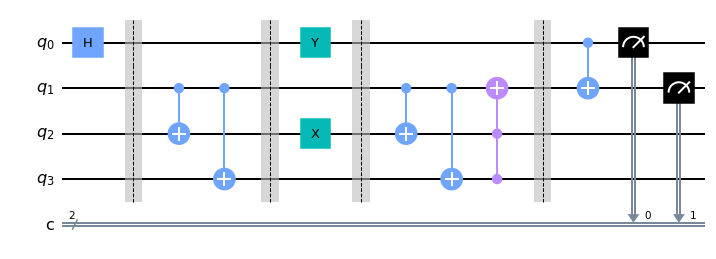

In [3]:
qc=QuantumCircuit(4, 2)
qc.h(0)
qc.barrier()
bit_flip_before(qc, 1)
# The error part
qc.barrier()
# You can put any Pauli on register 0 and any Pauli(just one) on registers 1,2 an 3.
qc.y(0)
qc.x(2)
qc.barrier()
bit_flip_after(qc, 1)
qc.barrier()
qc.cx(0, 1)
qc.measure(0, 0)
qc.measure(1, 1)
qc.draw("mpl")

A simple test. Let's get the measurement results for this circuit.

In [4]:
execute(qc, backend, shots=1000).result().get_counts()

{'00': 510, '11': 490}

The following function gets the errors we want to simulate and calculate the probability of observing $|00\rangle$.

In [5]:
def experiment(first,                # The error for first qubit. Must be in ["x", "y", "z"]
               second,               # The error for secon qubit. Must be in ["x", "y", "z"]
               position=1,           # Position of second qubit error on bit-flip code. Must be in range(1, 4)
               print_counts=False,   # Prints the detailed info of experiment
               draw=False,           # Draws the circuit
               num_shots=1000):      # Number of shots per experiment

    qc=QuantumCircuit(4, 2)
    qc.h(0)
    qc.barrier()
    bit_flip_before(qc, 1)
    qc.barrier()
    
    if first.upper() == "X":
        qc.x(0)
    elif first.upper() == "Y":
        qc.y(0)
    elif first.upper() == "Z":
        qc.z(0)
        
    if second.upper() == "X":
        qc.x(position)
    elif second.upper() == "Y":
        qc.y(position)
    elif second.upper() == "Z":
        qc.z(position)
        
    qc.barrier()
    bit_flip_after(qc, 1)
    qc.barrier()
    qc.cx(0, 1)
    qc.measure(0, 0)
    qc.measure(1, 1)
    
    counts=execute(qc, backend, shots=num_shots).result().get_counts()
    
    #
    # Auto checker to ensure only correct basis vectors 
    # are present in state vector.
    #
    if num_shots==1:
        assert "00" in counts or "11" in counts
    else:
        assert "00" in counts
        assert "11" in counts
    assert not "01" in counts
    assert not "10" in counts
    
    if draw:
        display(qc.draw("mpl"))
        
    if print_counts:
        print("******************************")
        print_str="The measurement counts for {} on wire 0 and {} on wire {} is:"
        print(print_str.format(first.upper(), second.upper(), position))
        print(counts)
        print("******************************")
    #
    # If number of shots is 1 the function returns the bit string of 
    # measurement outcome. If not it returns the probability of
    # observing |00>
    #
    if num_shots==1:
        return list(counts.keys())[0]
    else:
        return counts["00"]/1000

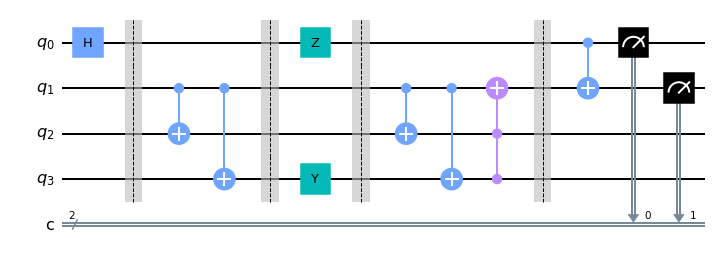

******************************
The measurement counts for Z on wire 0 and Y on wire 3 is:
{'00': 496, '11': 504}
******************************


0.496

In [6]:
experiment("z", "y", 3, print_counts=True, draw=True)

The final test consist of 40 different circuits created from different error scenarios. To simplify presenting the result, only the probability if $|00\rangle$ will be plotted. The numbers should all be close to $0.5$. Remember inside the function we made sure that only $|00\rangle$ and $|11\rangle$ can be the outcome of measurement.

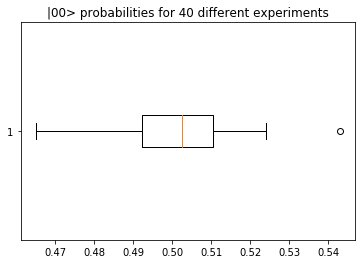

In [7]:
ket_00_probs=[]

for first in ["x", "y", "z", "i"]:
    ket_00_probs.append(experiment(first, "i"))
    for second in ["x", "y", "z"]:
        for position in range(1, 4):
            ket_00_probs.append(experiment(first, second, position))

fig1, ax1 = plt.subplots()
ax1.set_title('|00> probabilities for 40 different experiments')
ax1.boxplot(ket_00_probs, vert=False);

As predicted the results are all close to $0.5$.

This, in theory should conclude the first part but to implement the exact same experiment the task requires here is the following code:


In [8]:
Total_num_shots=1000
results = {"00":0, "01":0, "10":0, "11":0}
paulies = ["x", "y", "z", "i"]

for i in range(Total_num_shots):
    cr = experiment(paulies[randint(4)], paulies[randint(4)], randint(3), num_shots=1)
    results[cr] += 1
    
results

{'00': 467, '01': 0, '10': 0, '11': 533}

As predicted the distribution is correct.

# Part 2: The Shor code
As discussed above the previous experiment does not show the power of quantum error correction. Here is another, slightly more complicated experiment using Shor code for two qubits.
* Prepare a random two qubit quantum state.
* Caclulate the correct probabilities of computational basis measurements using state vector.
* Initialize a qc with that state and measure the state.
* Initialize another qc with same state and add two arbitrary random one qubit unitary and measue.
* Initialize a third qc with same state encode each qubit with Shor code, add two random one qubit error unitary and measure.
* Compare all the results.

In fact to be have a complete study we should do the measurement with all possible 15 Pauli tensor observables. But for simplicity we just do computational basis measurement.

In [9]:
#
# Helper functions to create Shor code. Here we have a qc with 18 qubits and arg "second" 
# indicates which qubit are we encoding, first or second.
#
def shor_before(qc, second=False):
    zero=second*9
    qc.cx(zero, zero+3)
    qc.cx(zero, zero+6)
    qc.h(zero)
    qc.h(zero+3)
    qc.h(zero+6)
    qc.cx(zero, zero+1)
    qc.cx(zero, zero+2)
    zero+=3
    qc.cx(zero, zero+1)
    qc.cx(zero, zero+2)
    zero+=3
    qc.cx(zero, zero+1)
    qc.cx(zero, zero+2)
    
def shor_after(qc, second=False):
    zero=second*9
    qc.cx(zero, zero+1)
    qc.cx(zero, zero+2)
    qc.ccx(zero+2, zero+1, zero)
    qc.h(zero)
    zero+=3
    qc.cx(zero, zero+1)
    qc.cx(zero, zero+2)
    qc.ccx(zero+2, zero+1, zero)
    qc.h(zero)
    zero+=3
    qc.cx(zero, zero+1)
    qc.cx(zero, zero+2)
    qc.ccx(zero+2, zero+1, zero)
    qc.h(zero)
    zero=second*9
    qc.cx(zero, zero+3)
    qc.cx(zero, zero+6)
    qc.ccx(zero+3, zero+6, zero)
    
def add_one_error(qc):
    qc.u(*np.random.randn(3), np.random.randint(9))
    qc.u(*np.random.randn(3), np.random.randint(9, 18))

In [10]:
def experiment_part2(state, noise=False):
    qc=QuantumCircuit(18, 2)
    qc.initialize(state, [0, 9])
    qc.barrier()
    shor_before(qc)
    shor_before(qc, second=True)
    qc.barrier()
    if noise:
        add_one_error(qc)
    qc.barrier()
    shor_after(qc)
    shor_after(qc, second=True)
    qc.barrier()
    qc.measure(0, 0)
    qc.measure(9, 1)
    #display(qc.draw("mpl"))
    res = execute(qc, backend, shots=1000).result().get_counts()
    if noise:
        print("Results: error gates:yes    correction:yes")
    else:
        print("Results: error gates:no     correction:no")
    print(res)
    
def noise_no_correction(state):
    qc=QuantumCircuit(2, 2)
    qc.initialize(state, [0, 1])
    qc.u(*np.random.randn(3), 0)
    qc.u(*np.random.randn(3), 1)
    qc.measure(0, 0)
    qc.measure(1, 1)
    res = execute(qc, backend, shots=1000).result().get_counts()
    print("Results: error gates:yes    correction:no")
    print(res)

In [11]:
state = np.random.randn(4) + np.random.randn(4) * 1j
state /= np.linalg.norm(state)
probs=[round(np.real(x*np.conj(x)), 3) for x in state]
probs_dict=results = {"00":probs[0], "01":probs[1], "10":probs[2], "11":probs[3]}
print("Correct probabilities:")
print(probs_dict)
noise_no_correction(state)
experiment_part2(state)
experiment_part2(state, noise=True)

Correct probabilities:
{'00': 0.025, '01': 0.694, '10': 0.192, '11': 0.089}
Results: error gates:yes    correction:no
{'00': 166, '01': 542, '10': 171, '11': 121}
Results: error gates:no     correction:no
{'00': 26, '01': 693, '10': 189, '11': 92}
Results: error gates:yes    correction:yes
{'00': 24, '01': 680, '10': 196, '11': 100}


As predicted adding aribrary one quibt error changes the outcome and Shor code can correct this error.